[[49.55   0.098  1.885  0.17 ]
 [49.481  0.253  1.882  0.   ]
 [49.107  0.406  1.87   0.   ]
 ...
 [ 6.689 -2.196 -3.167  0.   ]
 [ 6.678 -2.17  -3.158  0.   ]
 [ 6.702 -2.154 -3.167  0.   ]]
[602.93582267 600.6725604  598.39968906 ... 859.32486147 856.83552614
 854.1132479 ]
59039


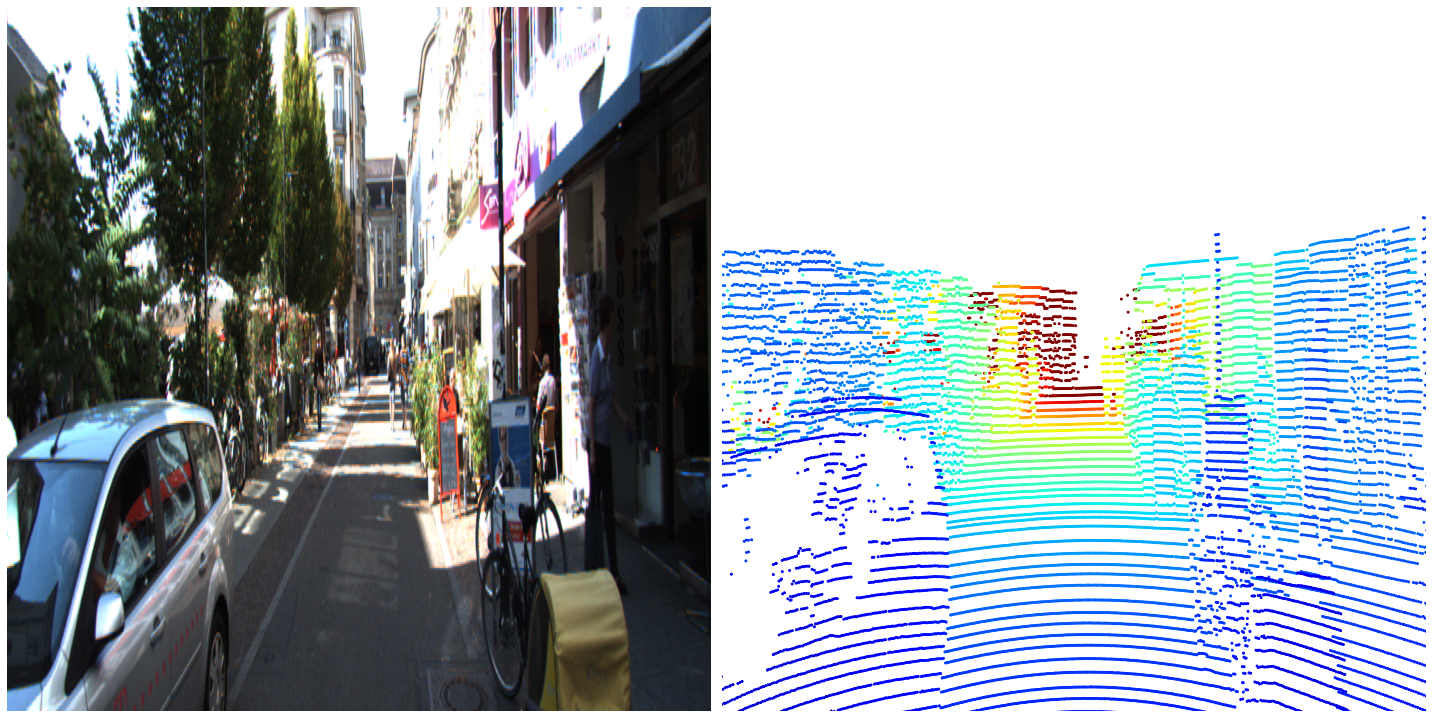

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 데이터 파일 경로
file_num = '000015'
calib_file = f'./calib/{file_num}.txt'
image_file = f'./training/image_2/{file_num}.png'
lidar_file = f'./vel/{file_num}.bin'

# 교정 파일 읽기 및 파싱
def read_calib_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    P0 = np.array([float(i) for i in lines[0].split(' ')[1:]]).reshape(3, 4)
    P1 = np.array([float(i) for i in lines[1].split(' ')[1:]]).reshape(3, 4)
    P2 = np.array([float(i) for i in lines[2].split(' ')[1:]]).reshape(3, 4)
    P3 = np.array([float(i) for i in lines[3].split(' ')[1:]]).reshape(3, 4)
    R0_rect = np.array([float(i) for i in lines[4].split(' ')[1:]]).reshape(3, 3)
    Tr_velo_to_cam = np.array([float(i) for i in lines[5].split(' ')[1:]]).reshape(3, 4)
    Tr_imu_to_velo = np.array([float(i) for i in lines[6].split(' ')[1:]]).reshape(3, 4)

    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo = read_calib_file(calib_file)

R0 = np.eye(4)
R0[:3, :3] = R0_rect
P = P2
Tr = np.vstack([Tr_velo_to_cam, [0, 0, 0, 1]])

# 이미지 읽기
img = cv2.imread(image_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# LiDAR 데이터 읽기
with open(lidar_file, 'rb') as f:
    data = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
    

# points[:, 0:3]
# print(data[:,1].shape)
# LiDAR 데이터를 이미지에 매핑
XYZ1 = np.vstack((data[:, :3].T, np.ones((1, data.shape[0]))))
xy1 = P @ R0 @ Tr @ XYZ1
# print("fsdfasfsa",XYZ1,"dfasdfdfff")
s = xy1[2, :]
x = xy1[0, :] / s
y = xy1[1, :] / s

k = s > 0

print((data[k]))

# 이미지의 가로세로 비율을 계산합니다.
aspect_ratio = float(img.shape[1]) / img.shape[0]

# Figure의 크기를 조정합니다.
# figsize의 첫 번째 값(너비)를 이미지의 가로세로 비율에 맞추어 조정합니다.
fig, axs = plt.subplots(1, 2, figsize=(20, 25 ))

# 이미지 subplot
axs[0].imshow(img_rgb)
axs[0].axis('off')  # 축 정보 끄기

# 포인트 클라우드 subplot
x_values = data[:, 0][k]  # X 값 추출

# 데이터의 실제 범위를 기반으로 색상 맵 스케일링
x_min, x_max = np.percentile(x_values, 1), np.percentile(x_values, 99)  # 1%에서 99% 범위로 잘라냄으로써 outlier의 영향을 줄입니다.
print(x[k])
print(len(y[k]))

# 컬러맵의 스케일을 조정합니다.
scatter = axs[1].scatter(x[k], img.shape[0] - y[k], c=x_values, cmap='jet', marker='.', s=15, vmin=x_min, vmax=x_max)
axs[1].set_xlim([0, img.shape[1]])
axs[1].set_ylim([0, img.shape[0]])
axs[1].axis('off')


# 색상 막대를 추가하여 x 값에 따른 색상 변화를 표시합니다.
# colorbar = fig.colorbar(scatter, ax=axs[1], fraction=0.02, pad=0.04)
# colorbar.set_label('X values')

# 서브플롯의 가로세로 비율을 이미지와 동일하게 설정합니다.
for ax in axs:
    ax.set_aspect(aspect_ratio)

plt.tight_layout()  # subplot 간격 조정
plt.show()



In [2]:
# # 방위각 계산
# angles = np.arctan2(data[:, 1], data[:, 0]) * (180 / np.pi)

# # 시야각 범위 설정 (예: 45도에서 -45도 사이)
# min_angle = -45
# max_angle = 45

# # 범위 내 포인트 필터링
# filtered_data = data[(angles >= min_angle) & (angles <= max_angle)]

# print(filtered_data)
# print(len(filtered_data))

In [2]:
# 방위각 계산
angles = np.arctan2(data[:, 1][k], data[:, 0][k]) * (180 / np.pi)
# data[:, 0][k]
# 시야각 범위 설정 (예: 45도에서 -45도 사이)
min_angle = -40
max_angle = 40

# 범위 내 포인트 필터링
filtered_data = data[k][(angles >= min_angle) & (angles <= max_angle)]

print(filtered_data)
print(len(filtered_data))

[[49.55   0.098  1.885  0.17 ]
 [49.481  0.253  1.882  0.   ]
 [49.107  0.406  1.87   0.   ]
 ...
 [ 6.689 -2.196 -3.167  0.   ]
 [ 6.678 -2.17  -3.158  0.   ]
 [ 6.702 -2.154 -3.167  0.   ]]
26012


[[683.5937782666474, 173.34695669023708, 709.9402370821402, 224.582883502841], [0, 200.0927356565906, 414.0034007623088, 373], [664.8549264908742, 174.5025007611227, 691.9591245066624, 224.64919246855632], [535.7156963036357, 167.80683249695377, 558.127886318258, 225.97348337770006], [998.0449681476634, 144.6223222693466, 1118.0212868005924, 320.1646202411758], [610.1937338918909, 172.7051790652388, 625.0840567175044, 205.482135125652]]


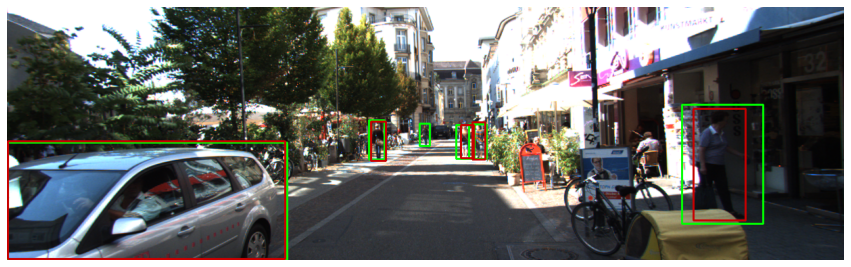

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw



def transform_to_camera_frame(boxes_lidar, Tr_velo_to_cam, R0_rect):
    """
    Transform the 3D bounding box coordinates from LiDAR frame to camera frame.
    """
    # Add a dummy dimension to boxes for homogeneous transformation
    ones = np.ones((boxes_lidar.shape[0], 1))
    boxes_lidar_hom = np.hstack((boxes_lidar[:, :3], ones))
    
    # Apply transformation: First, to camera frame, then apply rectification rotation
    boxes_cam_hom = np.dot(Tr_velo_to_cam, boxes_lidar_hom.T)
    boxes_cam = np.dot(R0_rect, boxes_cam_hom[:3, :])
    
    # Replace the transformed coordinates back into the box array
    transformed_boxes = np.hstack((boxes_cam.T, boxes_lidar[:, 3:]))
    
    return transformed_boxes

def project_to_image_plane(xy, P):
    """
    Project 3D points onto 2D image plane using the camera projection matrix P.
    """
    xy_homogeneous = np.hstack((xy[:, :3], np.ones((xy.shape[0], 1))))
    xy_projected = P @ xy_homogeneous.T
    xy_projected /= xy_projected[2, :]  # Normalize
    return xy_projected[:2, :].T

def compute_3d_box(box, Tr_velo_to_cam, R0_rect):
    """
    Compute the 3D bounding box corners and transform them to the camera frame.
    """
    x, y, z, w, l, h, yaw = box
    
    # Create rotation matrix for yaw
    R = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                  [np.sin(yaw),  np.cos(yaw), 0],
                  [0,            0,           1]])
    
    # 8 corners of the bounding box in local box coordinates
    local_corners = np.array([[ l / 2,  w / 2,  h / 2],  # Front top right
                              [ l / 2, -w / 2,  h / 2],  # Front top left
                              [-l / 2,  w / 2,  h / 2],  # Rear top right
                              [-l / 2, -w / 2,  h / 2],  # Rear top left
                              [ l / 2,  w / 2, -h / 2],  # Front bottom right
                              [ l / 2, -w / 2, -h / 2],  # Front bottom left
                              [-l / 2,  w / 2, -h / 2],  # Rear bottom right
                              [-l / 2, -w / 2, -h / 2]]) # Rear bottom left
    
    # Apply the rotation matrix to the corners
    rotated_corners = np.dot(R, local_corners.T).T
    
    # Translate the corners to global frame
    corners_lidar = rotated_corners + np.array([x, y, z])
    
    # Transform corners to camera frame
    corners_cam = transform_to_camera_frame(corners_lidar, Tr, R0_rect)
    
    return corners_cam





# Assuming P, R0, Tr, data, and img are already defined and loaded as per previous steps.

# LiDAR data to image plane mapping
XYZ1 = np.vstack((filtered_data[:, :3].T, np.ones((1, filtered_data.shape[0]))))  # Adding a row of ones for homogeneous coordinates
xy1 = P @ R0 @ Tr @ XYZ1  # Projecting LiDAR points onto the image plane
s = xy1[2, :]
x = (xy1[0, :] / s).astype(np.int32)
y = (xy1[1, :] / s).astype(np.int32)
k = s > 0

img_mapped = img.copy()  # Create a copy of the image to draw on
img_h, img_w = img.shape[:2]

# LiDAR 데이터를 이미지에 매핑하고, x 값에 따른 색상을 계산합니다.
x_normalized = (filtered_data[:, 0][k] - np.min(filtered_data[:, 0][k])) / (np.max(filtered_data[:, 0][k]) - np.min(filtered_data[:, 0][k]))
colors = plt.cm.magma(x_normalized)  # 'jet' 컬러맵을 사용하여 색상 계산

# # 이미지 위에 색상화된 포인트를 그립니다.
# for i, (ix, iy) in enumerate(zip(x[k], y[k])):
#     if 0 <= ix < img_w and 0 <= iy < img_h:
#         color = (colors[i] * 255).astype(np.uint8)[:3]  # RGBA에서 RGB로 변환
#         color = (int(color[2]), int(color[1]), int(color[0]))  # RGB에서 BGR로 변환
#         cv2.circle(img_mapped, (ix, iy), radius=5, color=color, thickness=-1)

# 이미지를 RGB로 변환합니다.
img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)

# 모델 출력에서 3D 바운딩 박스 정보 추출
# pred_boxes_3d = output['pred_boxes'].cpu().numpy()

# pred_boxes_3d = [[ 1.63371e+01,  2.91418e+00, -7.35781e-01,  3.96093e+00,  1.64973e+00,  1.64035e+00,  8.99297e-03],
#         [ 2.78689e+01,  1.26354e+01, -9.25614e-01,  3.82449e+00,  1.66333e+00,  1.48211e+00, -3.13488e+00],
#         [ 2.23875e+01, -2.49506e+00, -3.88692e-01,  1.83605e+00,  5.26783e-01,  1.79962e+00,  8.45754e-01],
#         [ 2.34667e+01,  5.96119e+00, -5.09889e-01,  5.10150e-01,  5.05686e-01,  1.62401e+00, -1.54370e+00],
#         [ 2.58533e+01,  1.61057e+01, -7.14150e-01,  1.12271e+00,  6.90278e-01,  1.90166e+00,  2.14460e-01],
#         [ 2.49313e+01, -2.64896e+00, -3.19039e-01,  4.60984e-01,  6.90923e-01,  1.79404e+00, -3.55881e-02],
#         [ 5.06992e+01,  1.79786e+01, -3.41854e-01,  9.99334e-01,  4.21662e-01,  1.87595e+00, -1.69113e+00],
#         [ 4.48696e+01,  3.46806e+01, -9.57657e-01,  3.72904e+00,  1.65231e+00,  1.52176e+00,  1.86742e+00],
#         [ 2.58734e+01, -1.66793e+00, -5.27849e-01,  8.18549e-01,  5.65653e-01,  1.61858e+00, -3.10288e-01]]
pred_boxes_3d = [[2.46599e+01, -3.09810e+00, -7.49772e-01,  7.15073e-01, 1.01342e+00,  1.69729e+00, -2.90156e-01],
                [ 4.34547e+00,  2.83154e+00, -9.92794e-01,  1.67443e+00, 4.26946e+00,  1.54297e+00,  2.98882e+00],
                [ 2.46276e+01, -2.45487e+00, -7.61330e-01,  7.51785e-01,  1.07473e+00,  1.65395e+00,  3.86464e-02],
                [ 2.36764e+01,  1.90852e+00, -6.01709e-01,  6.73733e-01,  1.12524e+00,  1.84334e+00,  4.79347e-02],
                [ 7.90610e+00, -4.74511e+00, -6.37877e-01,  8.18261e-01,  7.51732e-01,  1.73497e+00, -2.65735e+00],
                [ 4.09418e+01, -7.16393e-01, -6.18595e-01,  6.44788e-01,  6.80529e-01,  1.83207e+00, -2.84715e+00]]

# 3D bbox를 2D bbox로 투영
bboxes = []
bboxes_yolo = [[1.0, 198.0, 411.0, 372.0], [1015.0, 150.0, 1092.0, 315.0], [538.0, 169.0, 560.0, 227.0], [688.0, 170.0, 707.0, 225.0], [671.0, 174.0, 690.0, 223.0]]
for box in pred_boxes_3d:
    corners_cam = compute_3d_box(box, Tr_velo_to_cam, R0_rect)
    corners_2d = project_to_image_plane(corners_cam, P)
    
    # Compute 2D bounding box from corners
    x_min, y_min = np.min(corners_2d, axis=0)
    x_max, y_max = np.max(corners_2d, axis=0)
    
    
    x_min = max(0, min(x_min, img_w - 1))
    y_min = max(0, min(y_min, img_h - 1))
    x_max = max(0, min(x_max, img_w - 1))
    y_max = max(0, min(y_max, img_h - 1))
    
    bboxes.append([x_min, y_min, x_max, y_max])

# Draw bounding boxes on the image
for bbox in bboxes:
    start_point = (int(bbox[0]), int(bbox[1]))
    end_point = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(img_mapped_rgb, start_point, end_point, (0, 255, 0), 2)

for bbox in bboxes_yolo:
    start_point = (int(bbox[0]), int(bbox[1]))
    end_point = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(img_mapped_rgb, start_point, end_point, (200, 0, 0), 2)
    

print(bboxes)

# 이미지의 크기를 조절하고 시각화합니다.
plt.figure(figsize=(15, 10))
plt.imshow(img_mapped_rgb)
plt.axis('off')
plt.show()


# [-395.30040290168876, 204.97418010066716, 522.3233924625024, 597.3072716594444]
# [0, 204.97418010066716, 522.3233924625024, 373]
# [1.0, 198.0, 411.0, 372.0]

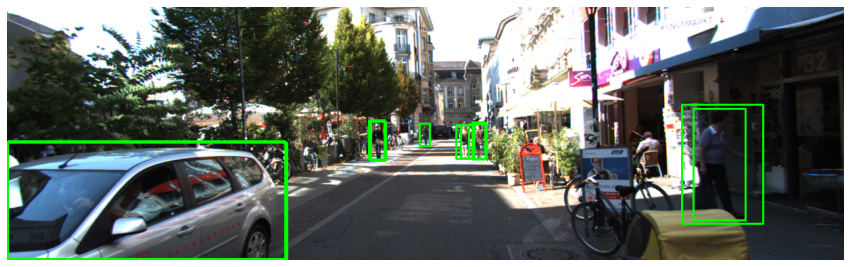

In [4]:
from scipy.optimize import linear_sum_assignment

# IOU를 계산하는 함수 정의
def calculate_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

# 비용 행렬 계산 (1 - IOU 값을 사용하여 비용을 계산)
cost_matrix = np.zeros((len(bboxes), len(bboxes_yolo)))

for i, lidar_box in enumerate(bboxes):
    for j, yolo_box in enumerate(bboxes_yolo):
        iou = calculate_iou(lidar_box, yolo_box)
        cost_matrix[i, j] = 1 - iou  # 1에서 IOU 값을 빼서 비용을 계산

# 헝가리안 알고리즘 적용
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 매칭 결과 출력
matching_result = list(zip(row_ind, col_ind))
matching_result, cost_matrix[row_ind, col_ind]

# Go through the matched indices and draw only the YOLO boxes
for yolo_idx in col_ind:
    yolo_box = bboxes_yolo[yolo_idx]
    start_point = (int(yolo_box[0]), int(yolo_box[1]))
    end_point = (int(yolo_box[2]), int(yolo_box[3]))
    color = (0, 255, 0)  # Green color for YOLO boxes
    thickness = 2
    img = cv2.rectangle(img_mapped_rgb, start_point, end_point, color, thickness)

# Convert color scheme from BGR to RGB for matplotlib display
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the retained YOLO boxes
plt.figure(figsize=(15, 10))
plt.imshow(img_mapped_rgb)
plt.axis('off')  # Hide the axis
plt.show()

In [16]:

matching_result, cost_matrix[row_ind, col_ind]


([(0, 3), (1, 0), (2, 4), (3, 2), (4, 1)],
 array([0.31512536, 0.02705934, 0.32678453, 0.19968818, 0.39674996]))

19.38m
4.89m
30.00m
35.10m
3.80m
34.04m
6.30m
3.31m
33.53m


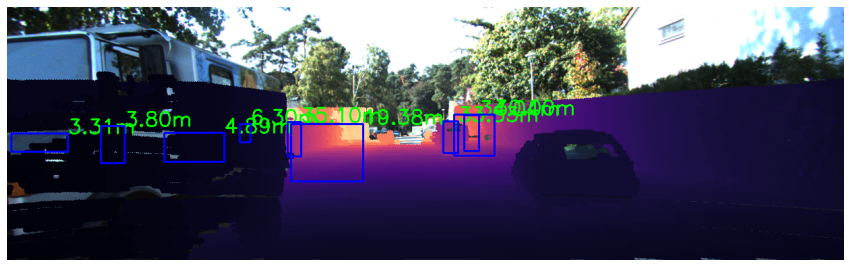

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Define bounding boxes
# bboxes = [
#     (684.2615, 173.37534, 709.95197, 224.61671),
#     (0., 198.61539, 412.19156, 373.),
#     (665.35706, 174.59393, 692.10803, 224.51292),
#     (536.50385, 167.87968, 558.10736, 225.84265),
#     (998.9549, 144.15085, 1120.0472, 320.33228),
#     (610.55927, 172.74219, 625.1432, 205.43327)
# ]
name = ['Pedestrian', 'Car', 'Pedestrian', 'Pedestrian', 'Pedestrian',
       'Pedestrian']




# Assuming P, R0, Tr, data, and img are already defined and loaded as per previous steps.

# LiDAR data to image plane mapping
# XYZ1 = np.vstack((data[:, :3].T, np.ones((1, data.shape[0]))))  # Adding a row of ones for homogeneous coordinates
# xy1 = P @ R0 @ Tr @ XYZ1  # Projecting LiDAR points onto the image plane
# s = xy1[2, :]
# x = (xy1[0, :] / s).astype(np.int32)
# y = (xy1[1, :] / s).astype(np.int32)

# img_mapped = img.copy()  # Create a copy of the image to draw on
# img_h, img_w = img.shape[:2]



# LiDAR 데이터를 이미지에 매핑하고, x 값에 따른 색상을 계산합니다.
# x_normalized = (data[:, 0][k] - np.min(data[:, 0][k])) / (np.max(data[:, 0][k]) - np.min(data[:, 0][k]))
# colors = plt.cm.magma(x_normalized)  # 'jet' 컬러맵을 사용하여 색상 계산

for i, (ix, iy) in enumerate(zip(x[k], y[k])):
    inside_bbox = False  # 초기에는 바운딩 박스 안에 없음으로 설정
    for bbox in bboxes:
        if bbox[0] <= ix <= bbox[2] and bbox[1] <= iy <= bbox[3]:
            inside_bbox = True  # 포인트가 바운딩 박스 내에 있음
            break  # 하나의 바운딩 박스에 포함되면 루프 종료
    if not inside_bbox:  # 어떤 바운딩 박스에도 포함되지 않으면 continue
        continue

    if 0 <= ix < img_w and 0 <= iy < img_h:
        color = (colors[i] * 255).astype(np.uint8)[:3]  # RGBA에서 RGB로 변환
        color = (int(color[2]), int(color[1]), int(color[0]))  # RGB에서 BGR로 변환
        cv2.circle(img_mapped, (ix, iy), radius=5, color=color, thickness=-1)
        
for i, bbox in enumerate(bboxes):
    # Filter the LiDAR points to only consider those in front of the LiDAR sensor (x >= 0)
    valid_points = filtered_data[(filtered_data[:, 0] >= 0) & (x >= bbox[0]) & (x <= bbox[2]) & (y >= bbox[1]) & (y <= bbox[3])]
    
    # Calculate the median depth value from the filtered points after removing outliers
    if valid_points.size > 0:
        sorted_depths = np.sort(valid_points[:, 0])
        trimmed_depths = sorted_depths[int(0.10 * len(sorted_depths)):int(0.99 * len(sorted_depths))]
        if trimmed_depths.size > 0:
            min_depth = np.min(trimmed_depths)
        else:
            min_depth = 0  # Default to 0 if no points are left after trimming
    else:
        min_depth = 0  # Default to 0 if no valid points are within the bbox
        
    
    # Place the median depth text at the top-right corner of the bounding box
    text = f"{min_depth:.2f}m"
    print(text)
    cv2.putText(img_mapped, text, (int(bbox[2]), int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)




# 이미지를 RGB로 변환합니다.
img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)


# Draw bounding boxes on the image
for bbox in bboxes:
    start_point = (int(bbox[0]), int(bbox[1]))
    end_point = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(img_mapped_rgb, start_point, end_point, (0, 0, 255), 2)

    

# 이미지의 크기를 조절하고 시각화합니다.
plt.figure(figsize=(15, 10))
plt.imshow(img_mapped_rgb)
plt.axis('off')
plt.show()





Pedestrian 18.65m
Car 3.16m
Pedestrian 24.25m
Pedestrian 23.39m
Pedestrian 3.87m
Pedestrian 40.75m


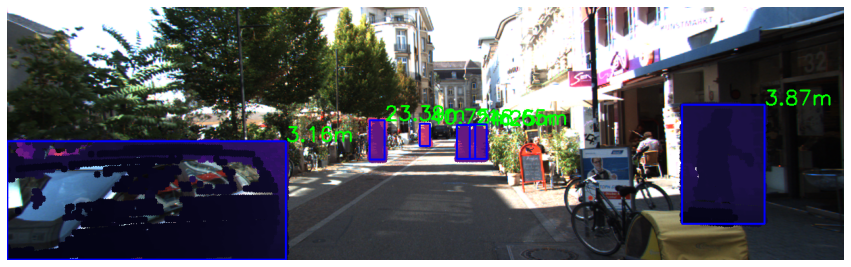

In [108]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Define bounding boxes
bboxes = [
    (684.2615, 173.37534, 709.95197, 224.61671),
    (0., 198.61539, 412.19156, 373.),
    (665.35706, 174.59393, 692.10803, 224.51292),
    (536.50385, 167.87968, 558.10736, 225.84265),
    (998.9549, 144.15085, 1120.0472, 320.33228),
    (610.55927, 172.74219, 625.1432, 205.43327)
]
name = ['Pedestrian', 'Car', 'Pedestrian', 'Pedestrian', 'Pedestrian',
       'Pedestrian']




# Assuming P, R0, Tr, data, and img are already defined and loaded as per previous steps.

# LiDAR data to image plane mapping
XYZ1 = np.vstack((data[:, :3].T, np.ones((1, data.shape[0]))))  # Adding a row of ones for homogeneous coordinates
xy1 = P @ R0 @ Tr @ XYZ1  # Projecting LiDAR points onto the image plane
s = xy1[2, :]
x = (xy1[0, :] / s).astype(np.int32)
y = (xy1[1, :] / s).astype(np.int32)

img_mapped = img.copy()  # Create a copy of the image to draw on
img_h, img_w = img.shape[:2]



# LiDAR 데이터를 이미지에 매핑하고, x 값에 따른 색상을 계산합니다.
x_normalized = (data[:, 0][k] - np.min(data[:, 0][k])) / (np.max(data[:, 0][k]) - np.min(data[:, 0][k]))
colors = plt.cm.magma(x_normalized)  # 'jet' 컬러맵을 사용하여 색상 계산

for i, (ix, iy) in enumerate(zip(x[k], y[k])):
    inside_bbox = False  # 초기에는 바운딩 박스 안에 없음으로 설정
    for bbox in bboxes:
        if bbox[0] <= ix <= bbox[2] and bbox[1] <= iy <= bbox[3]:
            inside_bbox = True  # 포인트가 바운딩 박스 내에 있음
            break  # 하나의 바운딩 박스에 포함되면 루프 종료
    if not inside_bbox:  # 어떤 바운딩 박스에도 포함되지 않으면 continue
        continue

    if 0 <= ix < img_w and 0 <= iy < img_h:
        color = (colors[i] * 255).astype(np.uint8)[:3]  # RGBA에서 RGB로 변환
        color = (int(color[2]), int(color[1]), int(color[0]))  # RGB에서 BGR로 변환
        cv2.circle(img_mapped, (ix, iy), radius=5, color=color, thickness=-1)
        
for i, bbox in enumerate(bboxes):
    # Filter the LiDAR points to only consider those in front of the LiDAR sensor (x >= 0)
    valid_points = data[(data[:, 0] >= 0) & (x >= bbox[0]) & (x <= bbox[2]) & (y >= bbox[1]) & (y <= bbox[3])]
    
    # Determine the depth as the minimum x-coordinate of valid points within the bounding box
    if valid_points.size > 0:
        min_depth = np.min(valid_points[:, 0])
    else:
        min_depth = 0  # If no valid points are in the bbox, we set a default value
    
    # Place the depth text at the top-right corner of the bounding box
    text = f"{min_depth:.2f}m"
    print(name[i],text)
    cv2.putText(img_mapped, text, (int(bbox[2]), int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)




# 이미지를 RGB로 변환합니다.
img_mapped_rgb = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB)


# Draw bounding boxes on the image
for bbox in bboxes:
    start_point = (int(bbox[0]), int(bbox[1]))
    end_point = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(img_mapped_rgb, start_point, end_point, (0, 0, 255), 2)

    

# 이미지의 크기를 조절하고 시각화합니다.
plt.figure(figsize=(15, 10))
plt.imshow(img_mapped_rgb)
plt.axis('off')
plt.show()





In [238]:
a = "000015.bin"
a[-10:-4]

'000015'